# HBOMax Analytics Code

## Data-Merging and Data Preparation

First, we use a dataset for HBO Max, were we have several variables that we would use in our dataset. Then, we want to populate the dataset using the OMDB API, which has fan information on millons of movies. We want to create a dataset with the original HBO movies, and add "voting count", which is a metric to evaluate movie popularity based on how many movies it has online. Additionally, we normalize titles to facilitate the merge, and notice that while some titles are dropped, these are titles in HBO that are not considered movies but are labeled as such

In [ ]:
import pandas as pd
import requests
import time
import re

hbo = pd.read_csv("HBO_MAX_Content.csv")
hbo["type"] = hbo["type"].fillna("")
hbo_movies = hbo[hbo["type"] != "TV"].copy()

OMDB_API_KEY = "b41a0262"
OMDB_URL = "http://www.omdbapi.com/"


def basic_title_normalize(title: str) -> str:
    if not isinstance(title, str):
        return ""
    t = re.sub(r"\s*\([^)]*\)", "", title)
    if ":" in t:
        t = t.split(":", 1)[0]
    t = t.replace("’", "'").replace("“", '"').replace("”", '"')
    return t.strip()


def clean_int_votes(x):
    if x in [None, "N/A", ""]:
        return None
    return int(x.replace(",", ""))


def fetch_imdb_votes(title, sleep=0.2):
    if not isinstance(title, str) or title.strip() == "":
        return None

    query_title = basic_title_normalize(title)
    if query_title == "":
        return None

    params = {
        "apikey": OMDB_API_KEY,
        "t": query_title,
        "type": "movie"
    }

    try:
        r = requests.get(OMDB_URL, params=params, timeout=5)
        data = r.json()
        time.sleep(sleep)
    except Exception:
        return None

    if data.get("Response") != "True":
        return None

    votes = clean_int_votes(data.get("imdbVotes"))

    return {
        "title": title,
        "imdb_votes": votes
    }


titles = hbo_movies["title"].dropna().unique()
rows = []

for t in titles:
    meta = fetch_imdb_votes(t)
    if meta is not None:
        rows.append(meta)

if rows:
    omdb_votes_df = pd.DataFrame(rows)
else:
    omdb_votes_df = pd.DataFrame(columns=["title", "imdb_votes"])

movies_enriched = hbo_movies.merge(
    omdb_votes_df,
    how="left",
    on="title"
)

movies_enriched.to_excel("HBO_Movies_OMDb_votes_only.xlsx", index=False)


We verify the merge was done correctly

In [ ]:
df = pd.read_excel("HBO_Movies_OMDb_votes_only.xlsx")

df

,index,title,type,year,rating,imdb_score,rotten_score,decade,imdb_bucket,genres_Action_Adventure,...,platforms_starz,platforms_sundancenow,platforms_syfy_tveverywhere,platforms_tbs,platforms_tnt,platforms_trutv_tveverywhere,platforms_urbanmoviechannel,platforms_velocity_go,platforms_watch_tcm,imdb_votes
0,2,The Lord of the Rings: The Fellowship of the Ring,NaN,2001,PG-13/TV-14,8.8,91.0,2000-2009,8.51-9.00,1,...,0,0,0,0,0,0,0,0,0,38480.0
1,3,Fight Club,NaN,1999,R/TV-MA,8.8,79.0,1990-1999,8.51-9.00,0,...,0,0,0,0,0,0,0,0,0,2536791.0
2,4,The Lord of the Rings: The Two Towers,NaN,2002,PG-13/TV-14,8.7,95.0,2000-2009,8.51-9.00,1,...,0,0,0,0,0,0,0,0,0,38480.0
3,5,The Lord of the Rings: The Return of the King,NaN,2003,PG-13/TV-14,8.9,93.0,2000-2009,8.51-9.00,1,...,0,0,0,0,0,0,0,0,0,38480.0
4,6,Spirited Away,NaN,2001,PG/TV-PG,8.6,97.0,2000-2009,8.51-9.00,1,...,0,0,0,0,0,0,0,0,0,938960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,2082,Mystery Signal From Space,NaN,2018,NaN,NaN,NaN,2010-2019,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
1708,2083,The Norwegian Fjords,NaN,2018,NaN,NaN,NaN,2010-2019,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
1709,2084,Mandrake Telefilm: Part 1,NaN,2013,NaN,NaN,NaN,2010-2019,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
1710,2085,What Animals See,NaN,2018,NaN,NaN,NaN,2010-2019,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN


We then decide heuristically to drop columns that serve no value to us (imdb_bucket, type, index, etc). We additionally remove platforms that are not relevant to HBO (Fubo is a sport platform that has no movies, so maybe 1-5 movies overlapp between the platform, so not necessary to keep, other cases are similar to this one).

In [ ]:
import pandas as pd

drop_cols = [
    "index",
    "type",
    "imdb_bucket"
]

df = df.drop(columns=drop_cols, errors="ignore")

platform_keep = [
    "platforms_netflix",
    "platforms_amazon_prime",
    "platforms_hulu_plus",
    "platforms_showtime",
    "platforms_starz"
]

platform_cols = [c for c in df.columns if c.startswith("platforms_")]

platform_drop = [c for c in platform_cols if c not in platform_keep]

df = df.drop(columns=platform_drop, errors="ignore")

df.head()


,title,year,rating,imdb_score,rotten_score,decade,genres_Action_Adventure,genres_Animation,genres_Anime,genres_Biography,...,genres_Sport,genres_Stand_up_Talk,genres_Thriller,genres_Travel,platforms_amazon_prime,platforms_hulu_plus,platforms_netflix,platforms_showtime,platforms_starz,imdb_votes
0,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13/TV-14,8.8,91.0,2000-2009,1,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
1,Fight Club,1999,R/TV-MA,8.8,79.0,1990-1999,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2536791.0
2,The Lord of the Rings: The Two Towers,2002,PG-13/TV-14,8.7,95.0,2000-2009,1,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
3,The Lord of the Rings: The Return of the King,2003,PG-13/TV-14,8.9,93.0,2000-2009,1,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
4,Spirited Away,2001,PG/TV-PG,8.6,97.0,2000-2009,1,1,1,0,...,0,0,0,0,0,0,0,0,0,938960.0


We inspect columns with missing values to evaluate what to do next. In this case, impute the mean value for rotten_score and impute the value "Unrated" for rating

In [ ]:
print("Total missing values per column:\n")
print(df.isna().sum().sort_values(ascending=False))

print("\nPercentage missing per column:\n")
print((df.isna().mean().sort_values(ascending=False) * 100).round(2))
print(len(df))

Total missing values per column:

rotten_score               500
rating                     465
imdb_votes                  79
imdb_score                  47
title                        0
decade                       0
genres_Action_Adventure      0
year                         0
genres_Animation             0
genres_Anime                 0
genres_Children              0
genres_Biography             0
genres_Crime                 0
genres_Cult                  0
genres_Documentary           0
genres_Comedy                0
genres_Family                0
genres_Fantasy               0
genres_Food                  0
genres_Game Show             0
genres_History               0
genres_Home_Garden           0
genres_Horror                0
genres_Drama                 0
genres_Independent           0
genres_LGBTQ                 0
genres_Mystery               0
genres_Musical               0
genres_Romance               0
genres_Science_Fiction       0
genres_Sport                 0
genre

After implemented the previously mentioned changes, we drop the target variable of imdb votes

In [ ]:
df["rating"] = df["rating"].fillna("Unrated")
df["rotten_score"] = df["rotten_score"].fillna(df["rotten_score"].mean())
df = df.dropna(subset=["imdb_score"])
df = df.dropna(subset=["imdb_votes"])
df = df.drop(columns=["title"], errors="ignore")

df


,year,rating,imdb_score,rotten_score,decade,genres_Action_Adventure,genres_Animation,genres_Anime,genres_Biography,genres_Children,...,genres_Sport,genres_Stand_up_Talk,genres_Thriller,genres_Travel,platforms_amazon_prime,platforms_hulu_plus,platforms_netflix,platforms_showtime,platforms_starz,imdb_votes
0,2001,PG-13/TV-14,8.8,91.000000,2000-2009,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
1,1999,R/TV-MA,8.8,79.000000,1990-1999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2536791.0
2,2002,PG-13/TV-14,8.7,95.000000,2000-2009,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
3,2003,PG-13/TV-14,8.9,93.000000,2000-2009,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38480.0
4,2001,PG/TV-PG,8.6,97.000000,2000-2009,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,938960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2011,PG/TV-PG,7.1,71.183168,2010-2019,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.0
1666,2011,G/TV-G,6.4,71.183168,2010-2019,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24.0
1667,2018,PG/TV-PG,4.3,71.183168,2010-2019,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,979.0
1672,2012,Unrated,5.4,71.183168,2010-2019,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125.0


With our data being prepared, we are now able to move on to explore the data shape and the different insights that it might provide us with

## Data Exploration Phase

**Setting Themes**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


**Distribution of IMDB Votes**

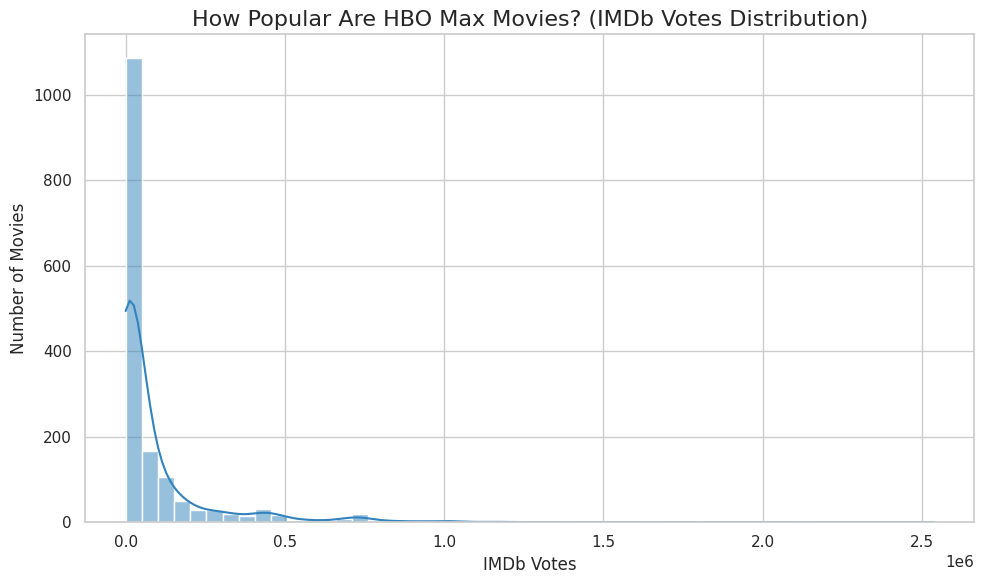

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df["imdb_votes"], bins=50, kde=True, color="#3182bd")
plt.title("How Popular Are HBO Max Movies? (IMDb Votes in Millions)", fontsize=16)
plt.xlabel("IMDb Votes")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


**Top 20 Movies by Popularity**

/tmp/ipython-input-3249364492.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


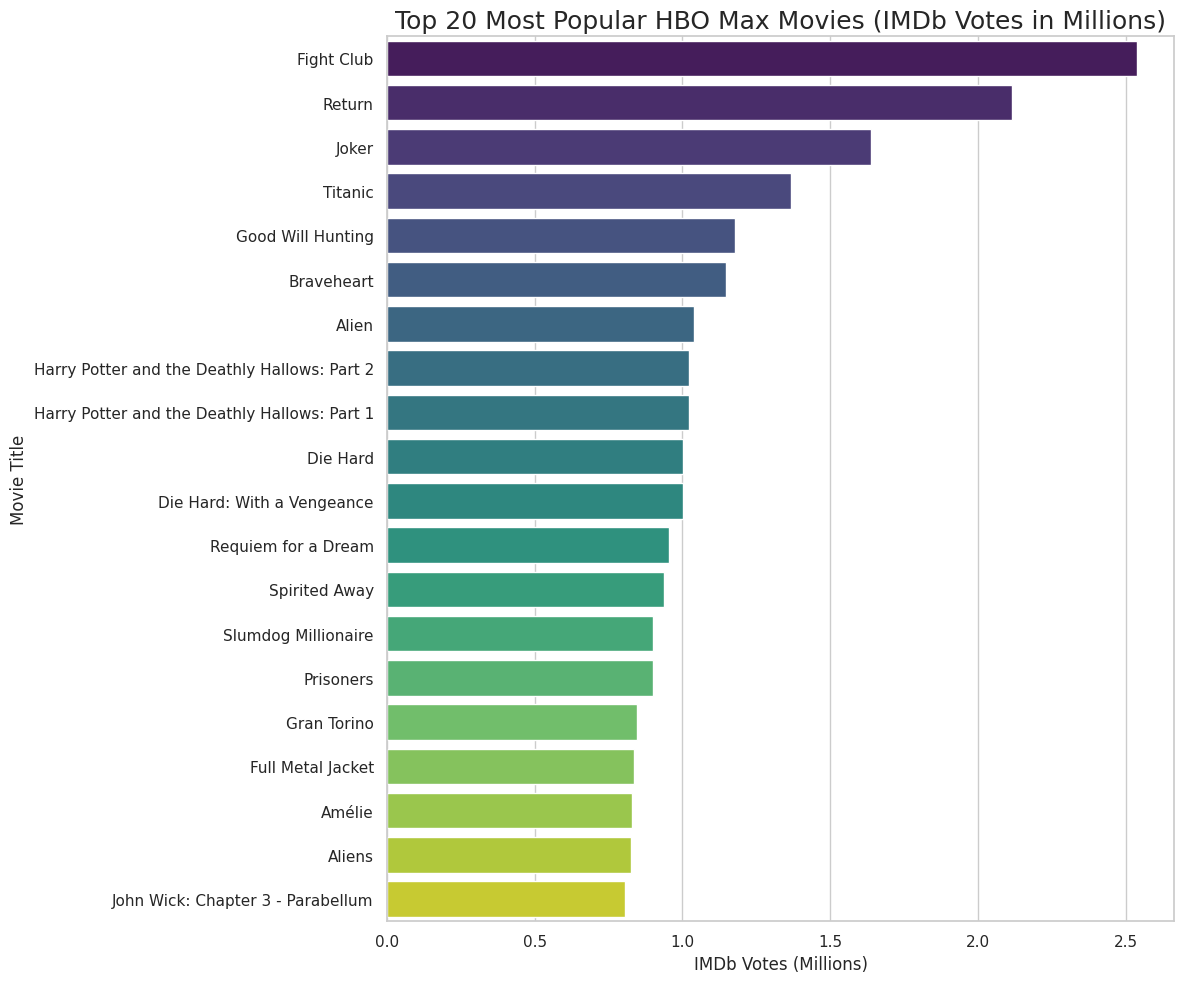

In [ ]:
df_plot = pd.read_excel("HBO_Movies_OMDb_votes_only.xlsx")

top20_idx = df["imdb_votes"].nlargest(20).index

top20 = df_plot.loc[top20_idx, ["title", "imdb_votes"]].copy()

top20 = top20.sort_values("imdb_votes", ascending=False)

top20["imdb_votes_millions"] = top20["imdb_votes"] / 1_000_000

plt.figure(figsize=(12, 10))
sns.barplot(
    data=top20,
    x="imdb_votes_millions",
    y="title",
    palette="viridis"
)

plt.title("Top 20 Most Popular HBO Max Movies (IMDb Votes in Millions)", fontsize=18)
plt.xlabel("IMDb Votes (Millions)")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()


**Average IMDb Votes by Decade (Millions)**

/tmp/ipython-input-1100807779.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


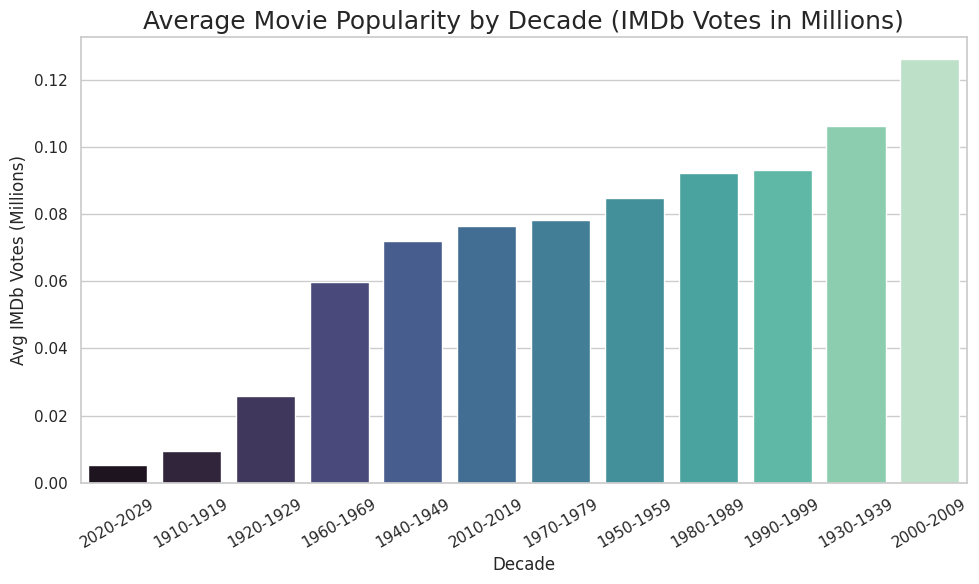

In [ ]:
df_plot["imdb_votes_millions"] = df_plot["imdb_votes"] / 1_000_000

decade_popularity = (
    df_plot.groupby("decade")["imdb_votes_millions"]
    .mean()
    .reset_index()
    .sort_values("imdb_votes_millions")
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=decade_popularity,
    x="decade",
    y="imdb_votes_millions",
    palette="mako"
)

plt.title("Average Movie Popularity by Decade (IMDb Votes in Millions)", fontsize=18)
plt.xlabel("Decade")
plt.ylabel("Avg IMDb Votes (Millions)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Average IMDB Votes by Genre (Millions)**

/tmp/ipython-input-2810447123.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


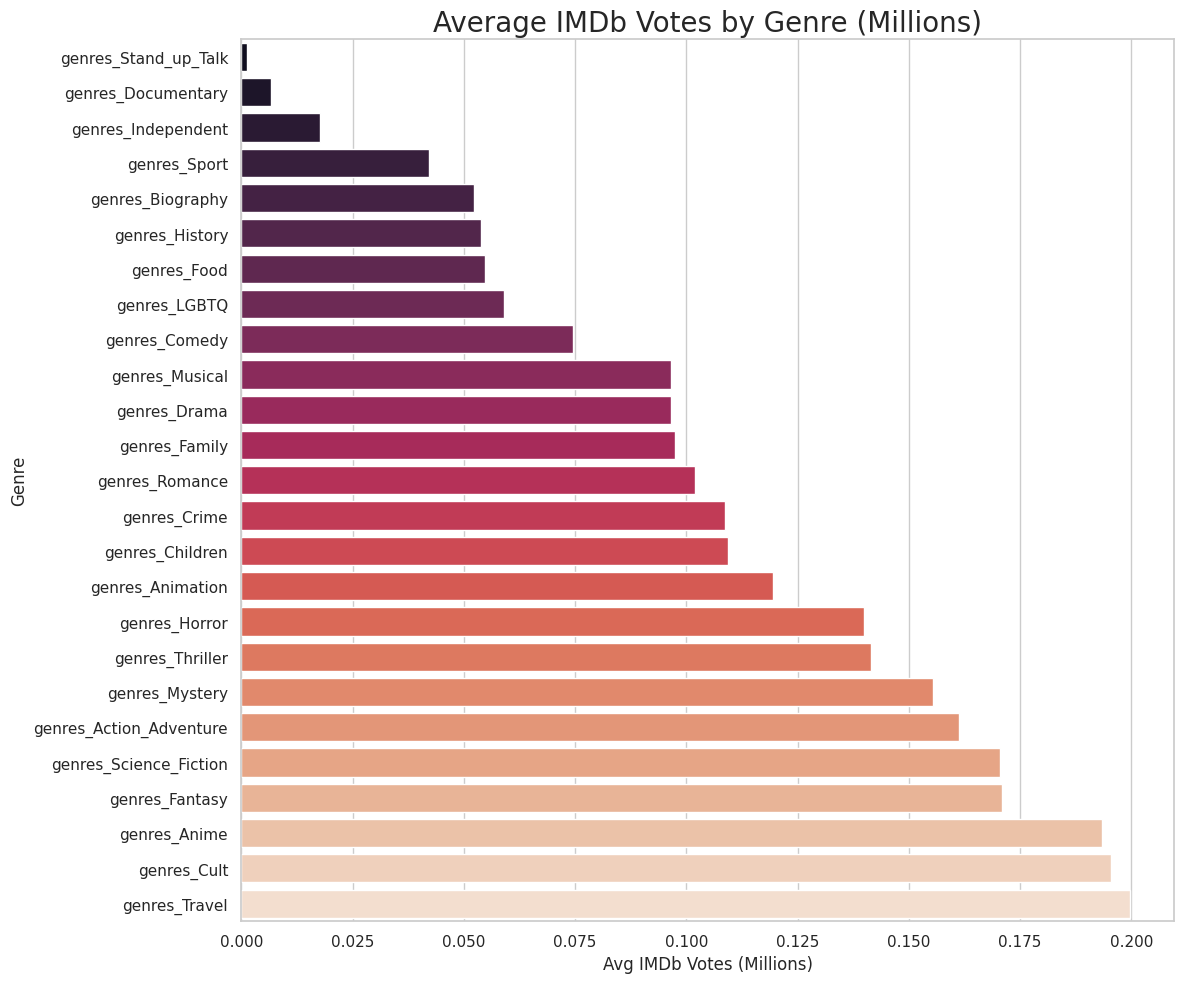

In [ ]:
genre_cols = [c for c in df_plot.columns if c.startswith("genres_")]

genre_melt = df_plot[genre_cols + ["imdb_votes"]].melt(
    id_vars=["imdb_votes"],
    var_name="genre",
    value_name="is_genre"
)

genre_melt = genre_melt[genre_melt["is_genre"] == 1]

genre_votes = (
    genre_melt.groupby("genre")["imdb_votes"]
    .mean()
    .div(1_000_000)
    .sort_values()
)

plt.figure(figsize=(12, 10))
sns.barplot(
    x=genre_votes.values,
    y=genre_votes.index,
    palette="rocket"
)

plt.title("Average IMDb Votes by Genre (Millions)", fontsize=20)
plt.xlabel("Avg IMDb Votes (Millions)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


**Critic vs Audience**

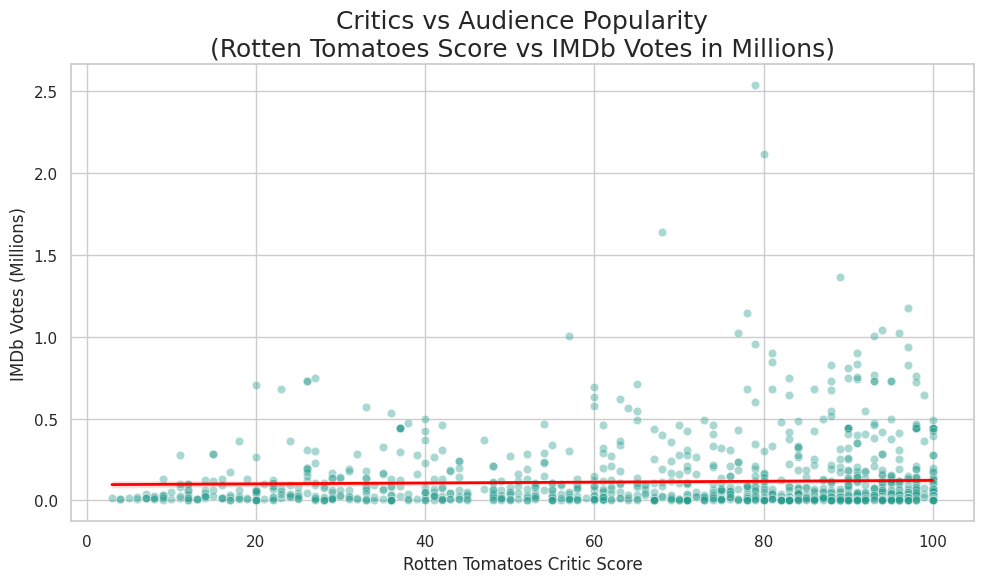

In [ ]:
df_plot["imdb_votes_millions"] = df_plot["imdb_votes"] / 1_000_000

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x="rotten_score",
    y="imdb_votes_millions",
    alpha=0.4,
    color="#2a9d8f"
)

sns.regplot(
    data=df_plot,
    x="rotten_score",
    y="imdb_votes_millions",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title("Critics vs Audience Popularity\n(Rotten Tomatoes Score vs IMDb Votes in Millions)", fontsize=18)
plt.xlabel("Rotten Tomatoes Critic Score")
plt.ylabel("IMDb Votes (Millions)")
plt.tight_layout()
plt.show()


## Model Building Stage

### Linear Regression

We performa log transormation as we evaluate that the data is non-linear, specially considering that the movies considered as blockbusters have an astounding number of reviews compared to most movies

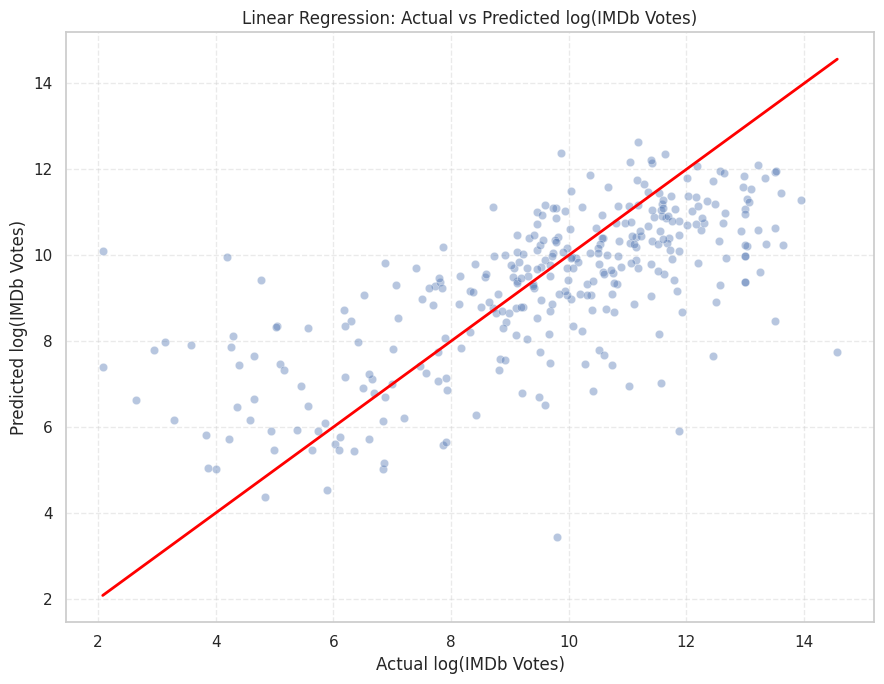


     LINEAR REGRESSION PERFORMANCE
     (Target: log(IMDb Votes))
R² Score:         0.4400
RMSE (log scale): 1.8979
MAE  (log scale): 1.4215



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df["log_votes"] = np.log1p(df["imdb_votes"])

y = df["log_votes"]
X = df.drop(columns=["imdb_votes", "log_votes"])

categorical_cols = ["rating", "decade"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

linear_model = Pipeline([
    ("prep", preprocessor),
    ("lr", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

plt.figure(figsize=(9,7))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.4)
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth=2)
plt.title("Linear Regression: Actual vs Predicted log(IMDb Votes)")
plt.xlabel("Actual log(IMDb Votes)")
plt.ylabel("Predicted log(IMDb Votes)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print("""
=========================================
     LINEAR REGRESSION PERFORMANCE
     (Target: log(IMDb Votes))
=========================================
R² Score:         {:.4f}
RMSE (log scale): {:.4f}
MAE  (log scale): {:.4f}
""".format(r2_lr, rmse_lr, mae_lr))


### Decision Tree

We optimize a decision tree with several parameters


     DECISION TREE PERFORMANCE
     (Target: log(IMDb Votes))
Best params:      {'max_depth': 7, 'min_samples_leaf': 10}
R² Score:         0.4999
RMSE (log scale): 1.7936
MAE  (log scale): 1.3353

On original votes scale:
RMSE:             188,103 votes
MAE:              75,133 votes



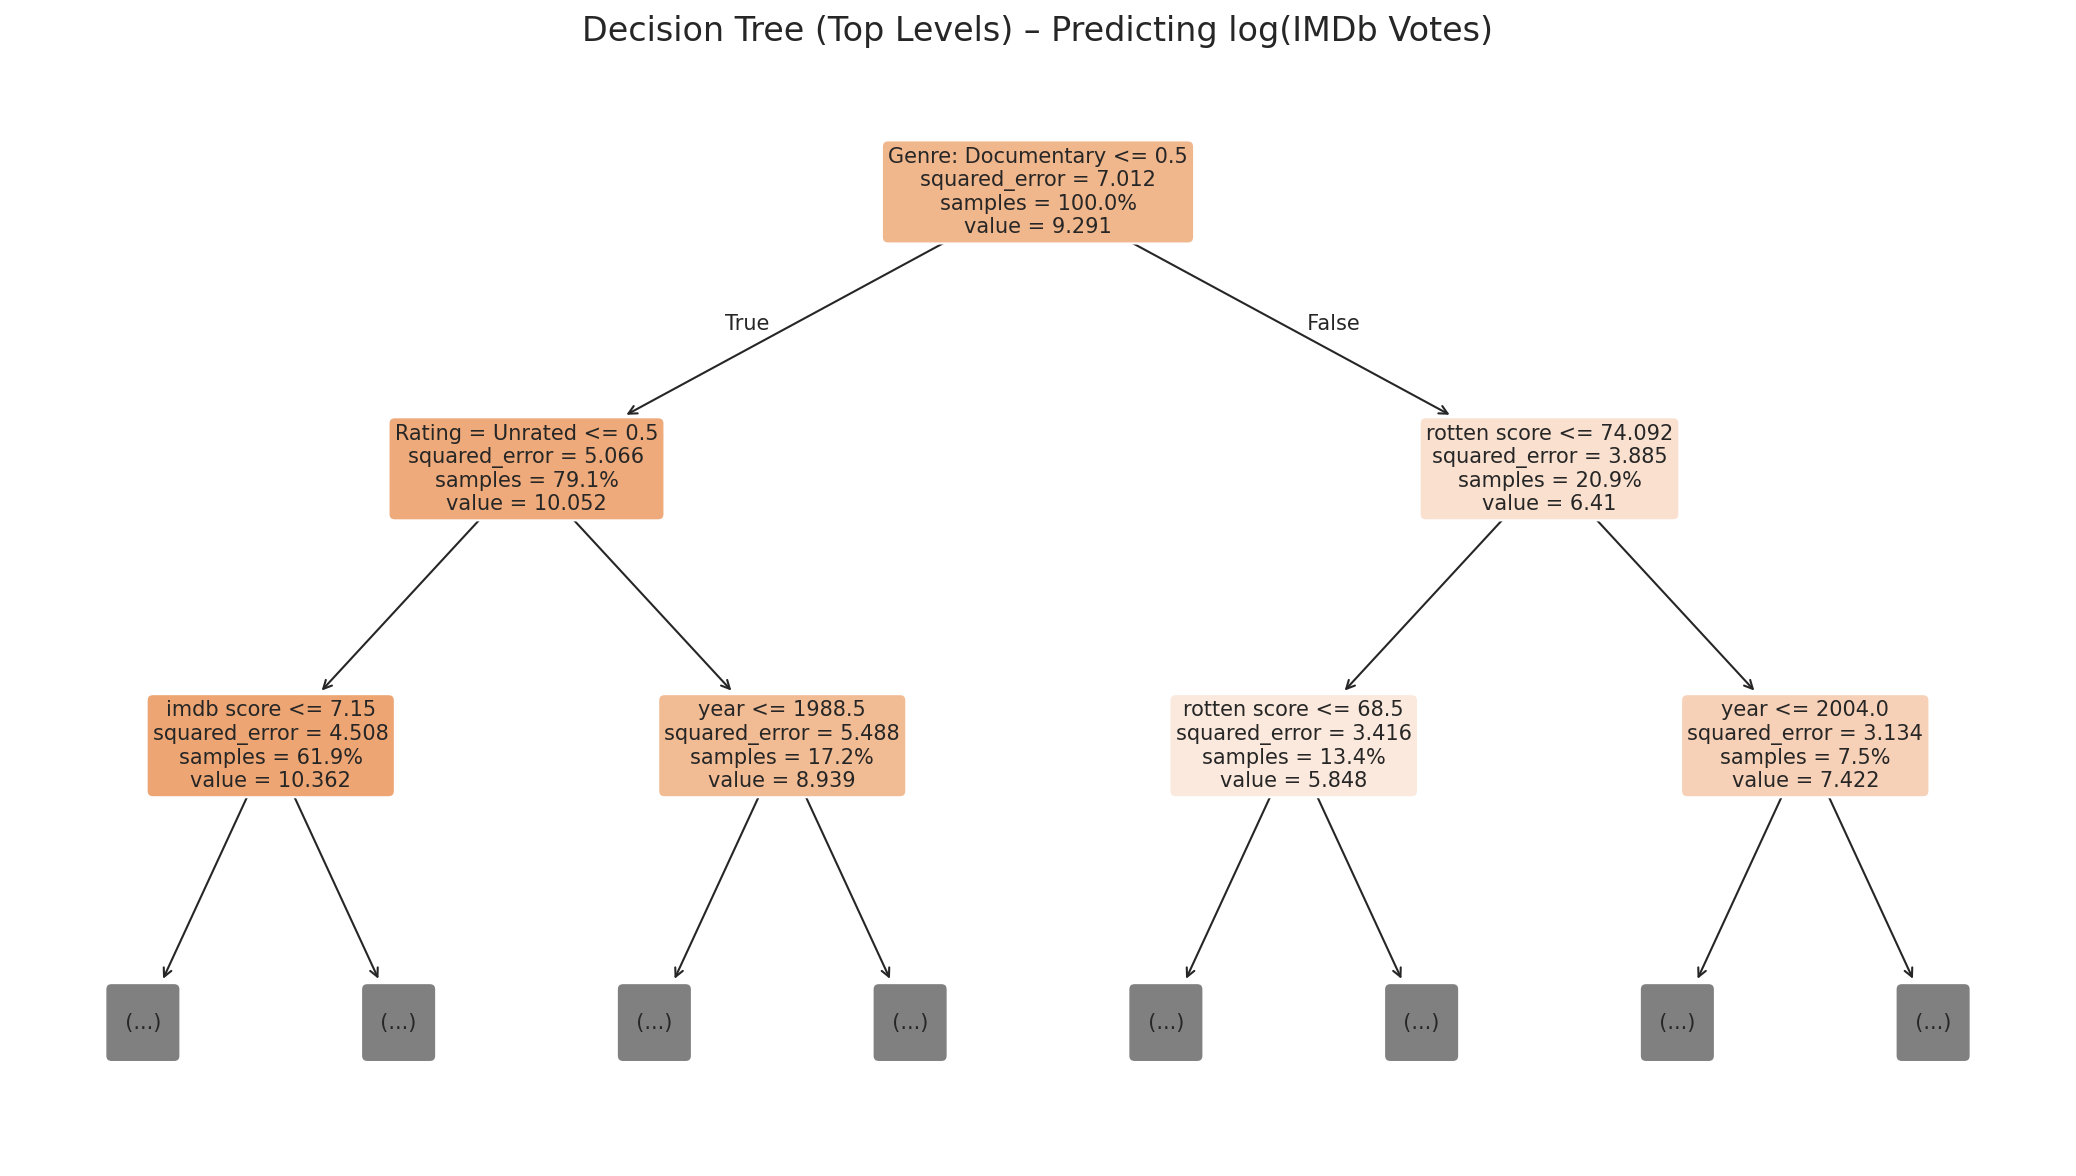

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

if "log_votes" not in df.columns:
    df["log_votes"] = np.log1p(df["imdb_votes"])

y = df["log_votes"]
X = df.drop(columns=["imdb_votes", "log_votes"], errors="ignore")

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

dt = DecisionTreeRegressor(random_state=42)
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [1, 5, 10, 20]
}

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

y_test_orig = np.expm1(y_test)
y_pred_dt_orig = np.expm1(y_pred_dt)
mse_dt_orig = mean_squared_error(y_test_orig, y_pred_dt_orig)
rmse_dt_orig = np.sqrt(mse_dt_orig)
mae_dt_orig = mean_absolute_error(y_test_orig, y_pred_dt_orig)

print("""
=========================================
     DECISION TREE PERFORMANCE
     (Target: log(IMDb Votes))
=========================================
Best params:      {}
R² Score:         {:.4f}
RMSE (log scale): {:.4f}
MAE  (log scale): {:.4f}

On original votes scale:
RMSE:             {:,.0f} votes
MAE:              {:,.0f} votes
""".format(grid.best_params_, r2_dt, rmse_dt, mae_dt, rmse_dt_orig, mae_dt_orig))

pretty_feature_names = []
for col in X_encoded.columns:
    if col.startswith("genres_"):
        name = col.replace("genres_", "Genre: ").replace("_", " ")
    elif col.startswith("platforms_"):
        name = col.replace("platforms_", "On: ").replace("_", " ")
    elif col.startswith("rating_"):
        name = col.replace("rating_", "Rating = ").replace("_", " ")
    elif col.startswith("decade_"):
        name = col.replace("decade_", "Decade = ")
    else:
        name = col.replace("_", " ")
    pretty_feature_names.append(name)

plt.figure(figsize=(14, 8), dpi=150)
plot_tree(
    best_dt,
    feature_names=pretty_feature_names,
    filled=True,
    rounded=True,
    max_depth=2,
    fontsize=10,
    proportion=True
)
plt.title("Decision Tree (Top Levels) – Predicting log(IMDb Votes)", fontsize=16)
plt.tight_layout()
plt.show()


### Random Forest

We finally conclude our model exploration with a random forest


     RANDOM FOREST PERFORMANCE
Best params:      {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
R² Score:         0.5886
RMSE (log):       1.6267
MAE  (log):       1.1881

Original scale:
RMSE:             187,344 votes
MAE:              73,190 votes



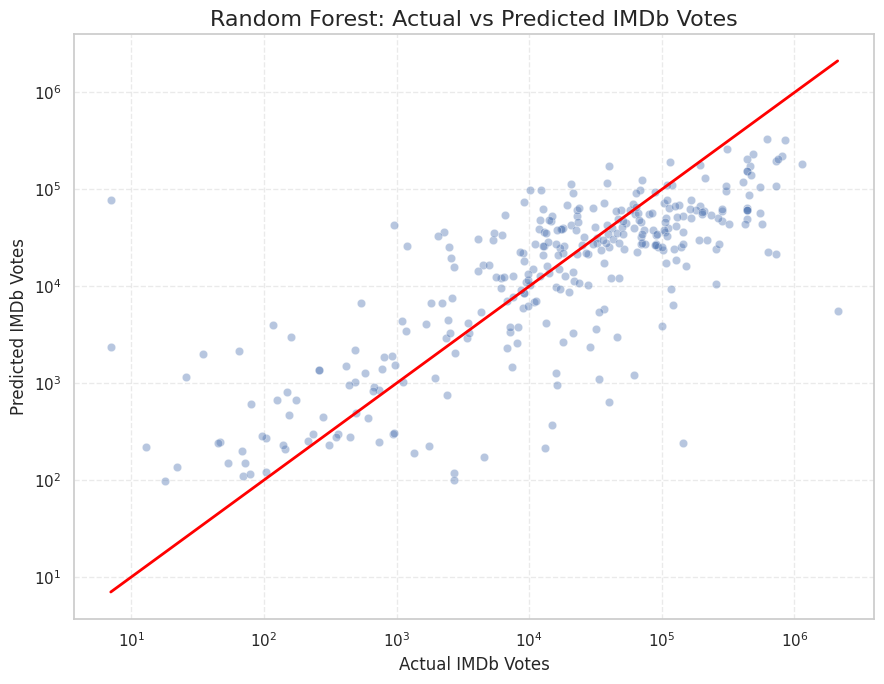

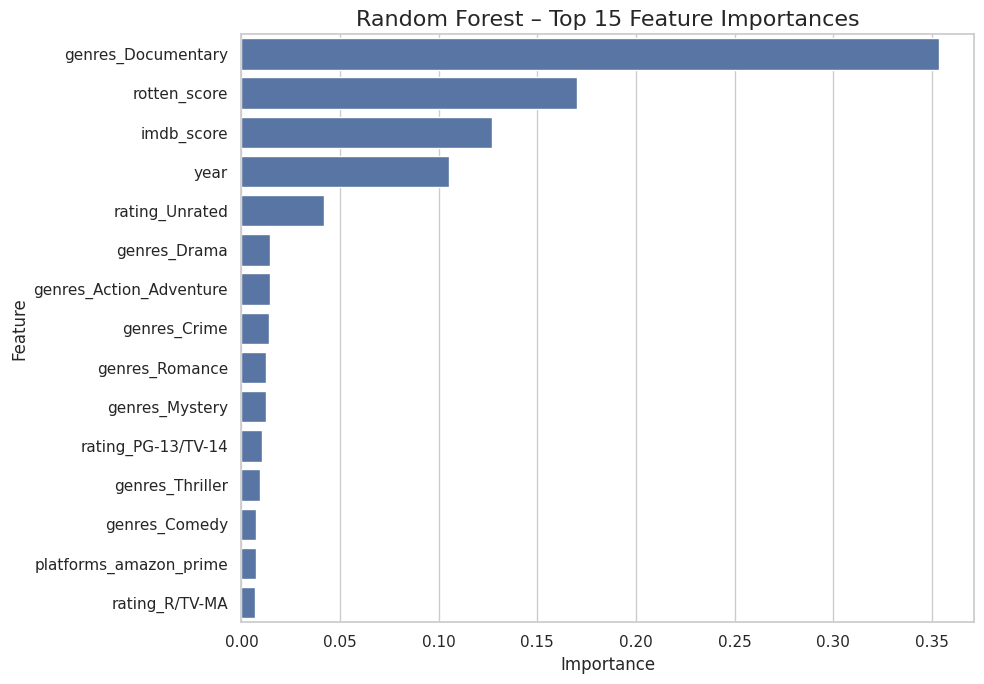

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df["log_votes"] = np.log1p(df["imdb_votes"])

y = df["log_votes"]
X = df.drop(columns=["imdb_votes", "log_votes"], errors="ignore")

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

y_test_orig = np.expm1(y_test)
y_pred_rf_orig = np.expm1(y_pred_rf)

mse_rf_orig = mean_squared_error(y_test_orig, y_pred_rf_orig)
rmse_rf_orig = np.sqrt(mse_rf_orig)
mae_rf_orig = mean_absolute_error(y_test_orig, y_pred_rf_orig)

print("""
=========================================
     RANDOM FOREST PERFORMANCE
=========================================
Best params:      {}
R² Score:         {:.4f}
RMSE (log):       {:.4f}
MAE  (log):       {:.4f}

Original scale:
RMSE:             {:,.0f} votes
MAE:              {:,.0f} votes
""".format(grid_rf.best_params_, r2_rf, rmse_rf, mae_rf, rmse_rf_orig, mae_rf_orig))

plt.figure(figsize=(9,7))
sns.scatterplot(x=y_test_orig, y=y_pred_rf_orig, alpha=0.4)
mn, mx = min(y_test_orig.min(), y_pred_rf_orig.min()), max(y_test_orig.max(), y_pred_rf_orig.max())
plt.plot([mn, mx], [mn, mx], color="red", linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.title("Random Forest: Actual vs Predicted IMDb Votes", fontsize=16)
plt.xlabel("Actual IMDb Votes")
plt.ylabel("Predicted IMDb Votes")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X_encoded.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(10,7))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Random Forest – Top 15 Feature Importances", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Evaluation


====== FINAL MODEL COMPARISON TABLE ======

            Model  R² (log scale)  RMSE (votes)  MAE (votes)
Linear Regression        0.440032 202367.751944 80658.007686
    Decision Tree        0.499889 188102.633213 75133.203613
    Random Forest        0.588634 187343.715025 73190.323630


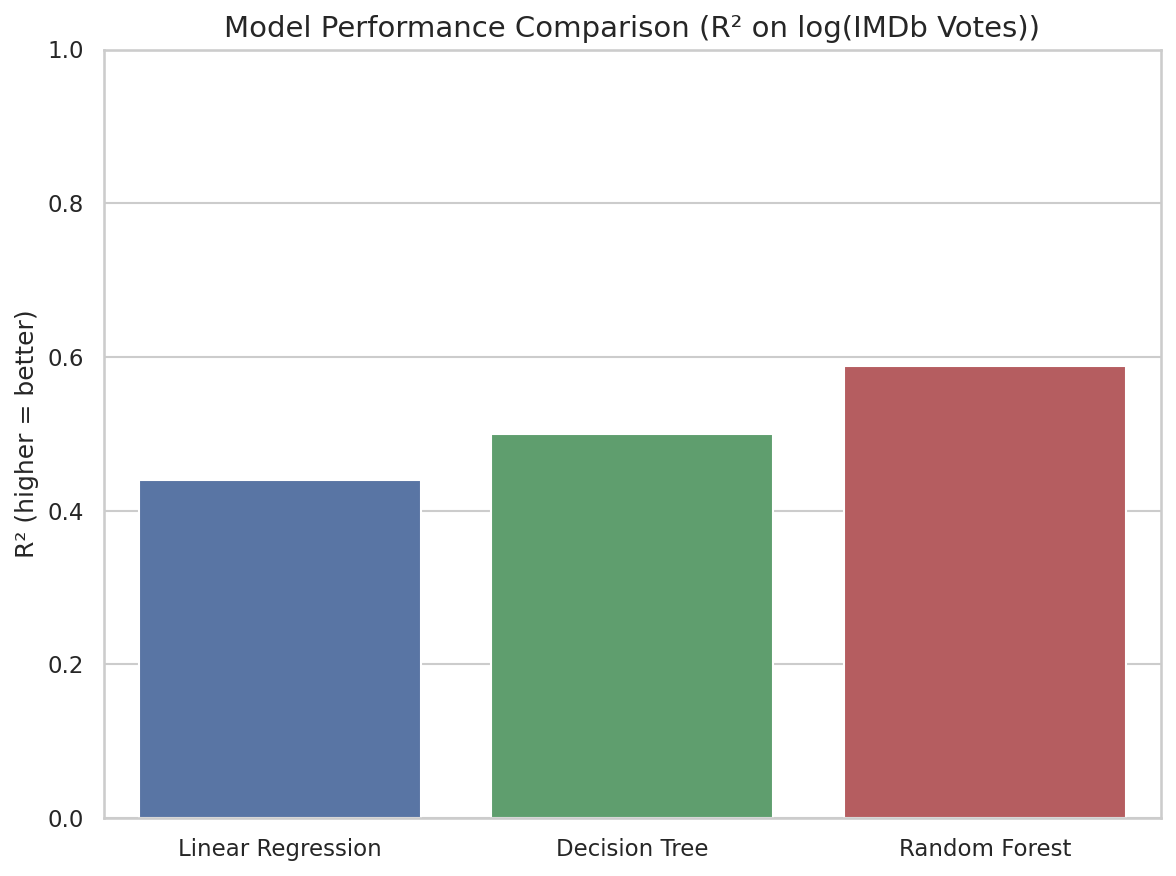

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test_orig = np.expm1(y_test)

y_pred_lr_orig = np.expm1(y_pred_lr)
rmse_lr_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_lr_orig))
mae_lr_orig = mean_absolute_error(y_test_orig, y_pred_lr_orig)

y_pred_dt_orig = np.expm1(y_pred_dt)
rmse_dt_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_dt_orig))
mae_dt_orig = mean_absolute_error(y_test_orig, y_pred_dt_orig)

y_pred_rf_orig = np.expm1(y_pred_rf)
rmse_rf_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_rf_orig))
mae_rf_orig = mean_absolute_error(y_test_orig, y_pred_rf_orig)

model_results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "R² (log scale)": [r2_lr, r2_dt, r2_rf],
    "RMSE (votes)":   [rmse_lr_orig, rmse_dt_orig, rmse_rf_orig],
    "MAE (votes)":    [mae_lr_orig, mae_dt_orig, mae_rf_orig]
})

print("\n====== FINAL MODEL COMPARISON TABLE ======\n")
print(model_results.to_string(index=False))

plt.figure(figsize=(8,6), dpi=150)
sns.barplot(
    data=model_results,
    x="Model",
    y="R² (log scale)",
    palette=["#4C72B0", "#55A868", "#C44E52"]
)
plt.title("Model Performance Comparison (R² on log(IMDb Votes))", fontsize=14)
plt.ylabel("R² (higher = better)")
plt.xlabel("")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

